In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [78]:
import random

def set_seed(seed):
    """
    Set the seed for reproducibility.
    """
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Set the seed for numpy for reproducibility
    random.seed(seed)  # Set Python random seed
    # Ensures that CUDA operations are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example: Setting the seed to 42
set_seed(42)

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 32
# Transform to convert images to PyTorch tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data for MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Using device: cpu


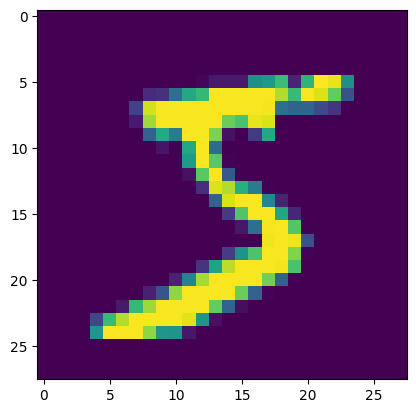

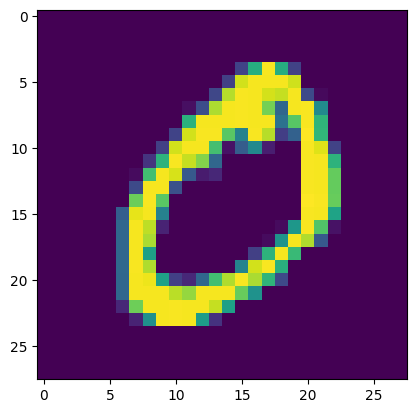

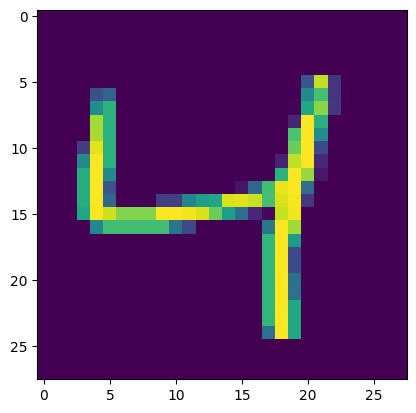

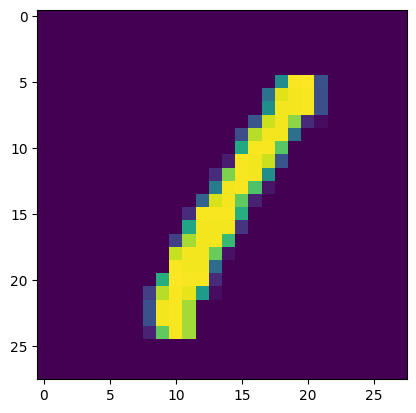

In [80]:
all_images = []
all_indices = []

for i, (images, labels) in enumerate(trainloader):
    all_images.extend(images)
    all_indices.extend(range(i * len(images), (i + 1) * len(images)))

# Convert the list to a NumPy array
all_images = torch.stack(all_images)
all_indices = torch.tensor(all_indices)



# Function to display an image given its index
def imshow_by_index(index):
    img = all_images[index] / 2 + 0.5  # Unnormalize
    plt.imshow(img.permute(1, 2, 0))  # Convert from Tensor image
    plt.show()

# Example: Display the first four images
for i in range(4):
    imshow_by_index(i)

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        # Assuming MNIST images are 1x28x28 (channels x width x height)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2) # Output: 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2) # Output: 64x14x14
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Output: 64x7x7 after pooling

        # Flatten: 64*7*7 = 3136 features
        self.fc1 = nn.Linear(3136, 128) # Fully connected layer

        self.fc2 = nn.Linear(128, 64) # Additional fully connected layer
        self.fc3 = nn.Linear(64, 10) # Final layer for classifying into 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        x1 = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x1))
        x = self.fc3(x)
        return x


In [82]:
# Initialize the network and move it to the device
net = MNISTNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
def train(net, trainloader, device, criterion, optimizer, epochs=2):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")



# Testing loop
def test(net, testloader, device):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %f %%' % (100 * correct / total))

# Train and test the network
train(net, trainloader, device, criterion, optimizer)


Epoch 1, Loss: 0.14553034588180017
Epoch 2, Loss: 0.047943626788207135


In [83]:
test(net, testloader, device)

Accuracy of the network on the 10000 test images: 98.630000 %


In [84]:
class TrainableNode(nn.Module):
    def __init__(self, input_features, output_features):
        super(TrainableNode, self).__init__()
        self.linear = nn.Linear(input_features, output_features)
        self.is_explainable = True
    def forward(self, x):
        return self.linear(x)

# Step 1: Add the new layer
net.explainable_node = TrainableNode(128, 1).to(device)

# Step 2: Dynamically override the forward method
def new_forward(self, x, return_explainable=False):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    # Flatten the output for the fully connected layers
    x = x.view(x.size(0), -1)

    x1 = F.relu(self.fc1(x))

    if return_explainable:
        explainable_output = self.explainable_node(x1).squeeze()

    x = F.relu(self.fc2(x1))
    x = self.fc3(x)

    if return_explainable:
        return x, explainable_output
    return x

# Assign the new forward method to the net instance
net.forward = new_forward.__get__(net, MNISTNet)

# Optionally, if you want to directly use the explainable forward method without affecting the original forward method
def forward_with_explainable(self, x):
    # This example assumes you want to pass the original input through the explainable node directly
    # Adjust accordingly if you meant something different
    explainable_output = self.explainable_node(x).squeeze()
    return explainable_output

# Assign this method as well if needed
net.forward_with_explainable = forward_with_explainable.__get__(net, MNISTNet)


In [85]:
class ExplainableNetwork:
    def __init__(self, model):
        self.model = model
        self.activations_per_input = {}
        self.gradients_per_input = {}
        self.batch_counter = 0
        self.layer_names = []
        self.explainable_module_names = set()
        explainable_module_names = set()
        self.expected_outputs = []
        self.predicted_outputs = []
        for name, module in model.named_modules():
            if getattr(module, 'is_explainable', False):
                explainable_module_names.add(name)
        for name, module in model.named_modules():
            if name and not any(part in explainable_module_names for part in name.split('.')):
                if isinstance(module, torch.nn.Linear):
                    self.layer_names.append(name)
            elif name:
                self.explainable_module_names.add(name)

        self.expected_outputs = []
        self.predicted_outputs = []

        self.hook_handles = []

        self.enable_hooks()

    # def getNonExpLayers(model):
    #     layers = []
    #     for name, module in model.named_modules():
    #         if name != '' and not isinstance(module, TrainableNode):
    #             layers.append(name)
    #     return layers

    # Register hooks for each layer
    def enable_hooks(self):
        for name, module in self.model.named_modules():
            if name in self.explainable_module_names:  # Skip the explainable_node by its name
                continue
            # Check if the module is a type that we want to hook (Conv2d, Linear, or pooling layers)
            if isinstance(module, torch.nn.Linear):
                forward_handle = module.register_forward_hook(self.create_forward_hook(name))
                backward_handle = module.register_full_backward_hook(self.create_backward_hook(name))
                self.hook_handles.append(forward_handle)
                self.hook_handles.append(backward_handle)
    def disable_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []  # Clear the list after removing all hooks

    def create_forward_hook(self, layer_name):
        def forward_hook(module, input, output):
            self.store_activations(layer_name, output)
        return forward_hook

    def create_backward_hook(self, layer_name):
        def backward_hook(module, grad_input, grad_output):
            self.store_gradients(layer_name, grad_output[0])
        return backward_hook
    def store_activations(self, layer_name, output):
        self._store_per_input(self.activations_per_input, layer_name, output)

    def store_gradients(self, layer_name, gradient):
        # Store gradients for the last epoch
        batch_size = gradient.size(0)
        for i in range(batch_size):
            input_index = self.batch_counter * batch_size + i
            if input_index not in self.gradients_per_input:
                self.gradients_per_input[input_index] = {}
            self.gradients_per_input[input_index][layer_name] = gradient[i].detach().cpu().numpy()

            # Increment the backward batch counter only after processing the first layer (which is the last layer in the forward pass)


    def _store_per_input(self, storage_dict, layer_name, tensor):
        batch_size = tensor.size(0)
        for i in range(batch_size):
            input_index = self.batch_counter * batch_size + i
            if input_index not in storage_dict:
                storage_dict[input_index] = {}
            storage_dict[input_index][layer_name] = tensor[i].detach().cpu().numpy()

        if layer_name == self.layer_names[-1]:
            self.batch_counter += 1

    def get_activations(self, input_index):
        return self.activations_per_input.get(input_index, None)

    def get_gradients(self, input_index):
        return self.gradients_per_input.get(input_index, None)

    def print_structure(self):
        print("Explainable Network Structure and Data Summary:")

        # Check if there is any data collected
        if not self.activations_per_input:
            print("No activations data collected.")
            return

        if not self.gradients_per_input:
            print("No gradients data collected.")
            return

        # Print information about activations
        print("\nActivations:")
        first_input_activations = next(iter(self.activations_per_input.values()))
        for layer_name, activations in first_input_activations.items():
            num_nodes = len(activations)
            num_data_points = len(self.activations_per_input)
            print(f"Layer {layer_name}: {num_nodes} nodes, {num_data_points} data points each")

        # Print information about gradients
        print("\nGradients:")
        first_input_gradients = next(iter(self.gradients_per_input.values()))
        for layer_name, gradients in first_input_gradients.items():
            num_nodes = len(gradients)
            num_data_points = len(self.gradients_per_input)
            print(f"Layer {layer_name}: {num_nodes} nodes, {num_data_points} data points each")

    # FIXME: Add functionality for first layer
    def get_node_input(self, layer_name, node_index, image_index):
        if layer_name != self.layer_names[0] and layer_name in self.layer_names:
            # For subsequent layers, we use activations from the previous layer
            prev_layer_name = self.get_previous_layer_name(layer_name)
            prev_activations = self.activations_per_input[image_index][prev_layer_name]

            # Ensure the prev_activations is a 1D array for proper multiplication
            if prev_activations.ndim > 1:
                prev_activations = prev_activations.flatten()

        return prev_activations

    def find_extreme_activations(self, std_dev_threshold=3, label_digit=0, pred_digit=0):
            """
            Find inputs where node activations are more than +3 or less than -3 standard deviations from the mean.

            Args:
            std_dev_threshold (float): The number of standard deviations to use as a threshold for extreme activations.

            Returns:
            dict: A dictionary containing two keys ('high' and 'low') each mapping to a dict of nodes and their corresponding extreme input indices.
            """

            # Calculate mean and standard deviation for each node
            node_stats = {}  # Dictionary to store mean and std for each node
            for _, layers_activations in self.activations_per_input.items():
                for layer_name, activations in layers_activations.items():
                    if layer_name not in node_stats:
                        node_stats[layer_name] = []
                    node_stats[layer_name].append(activations)

            for layer_name, activations_list in node_stats.items():
                node_stats[layer_name] = {
                    'mean': np.mean(activations_list, axis=0),
                    'std': np.std(activations_list, axis=0)
                }

            activations_structure = {}

            # Assuming 'model' is your neural network model
            for name in self.layer_names:
                activations_structure[name] = {'high': {}, 'low': {}}

            # Identify inputs with extreme activations
            for input_index, layers_activations in self.activations_per_input.items():
                for layer_name, activations in layers_activations.items():
                    if self.expected_outputs[input_index] == label_digit and self.predicted_outputs[input_index] == pred_digit:
                        mean = node_stats[layer_name]['mean']
                        std = node_stats[layer_name]['std']
                        high_threshold = mean + std_dev_threshold * std
                        low_threshold = mean - std_dev_threshold * std

                        high_indices = np.where(activations > high_threshold)[0]
                        low_indices = np.where(activations < low_threshold)[0]

                        for idx in high_indices:
                            activations_structure[layer_name]['high'][idx] = activations_structure[layer_name]['high'].get(idx, 0) + 1
                        for idx in low_indices:
                            activations_structure[layer_name]['low'][idx] = activations_structure[layer_name]['low'].get(idx, 0) + 1
            return activations_structure

    def get_previous_layer_name(self, current_layer_name):
        try:
            index = self.layer_names.index(current_layer_name)
        except ValueError:
            print("Layer name not found in the model.")
            return None

        if index == 0:
            return None
        else:
            return self.layer_names[index - 1]





In [86]:
explainable_net = ExplainableNetwork(net)

In [87]:
net.train()  # Set the network to training mode

for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)

    # Zero the parameter gradients
    net.zero_grad()

    # Forward pass
    outputs = net(images)

    # Calculate loss
    loss = criterion(outputs, labels)

    # Backward pass to compute gradients
    loss.backward()

    explainable_net.expected_outputs.extend(labels.cpu().numpy())

    # Convert outputs to predicted class labels
    _, predicted = torch.max(outputs, 1)
    explainable_net.predicted_outputs.extend(predicted.cpu().numpy())

In [88]:
# print(explainable_net.get_activations(0)['conv1'].shape)
print(explainable_net.get_activations(0)['fc2'].shape)

(64,)


In [89]:
explainable_net.print_structure()

Explainable Network Structure and Data Summary:

Activations:
Layer fc1: 128 nodes, 60000 data points each
Layer fc2: 64 nodes, 60000 data points each
Layer fc3: 10 nodes, 60000 data points each

Gradients:
Layer fc3: 10 nodes, 60000 data points each
Layer fc2: 64 nodes, 60000 data points each
Layer fc1: 128 nodes, 60000 data points each


In [90]:
inputs = all_images[12].unsqueeze(0).to(device)  # Add a batch dimension

net.eval()

# Forward pass to get both outputs
with torch.no_grad():
    regular_output, explainable_output = net(inputs, return_explainable=True)

print("Regular Output:", regular_output)
print("Explainable Output:", explainable_output)

Regular Output: tensor([[ -8.7515,   0.0375,   0.3405,  17.5614,  -2.5146,  -0.1269, -10.5089,
           4.2784,  -0.7991,  -0.7350]])
Explainable Output: tensor(-2.4690)


In [91]:
# Normalizes the predictions (i, j) to the total number of predictions(i, _) for all predictions
# Returns a 2D array such that probabilities[i][j] holds the probability of the model
# predicting last_layer[i] as last_layer[j]
def calculate_probabilities(classifier_outcomes, label_counts):
    probabilities = np.zeros_like(classifier_outcomes, dtype=np.float64)
    for i in range(len(label_counts)):
        if label_counts[i] > 0:  # Prevent division by zero
            probabilities[i] = classifier_outcomes[i] / label_counts[i]
    return probabilities

In [92]:
net.eval()
correct = 0
total = 0

for layer_name, module in explainable_net.model.named_modules():
    if layer_name == explainable_net.layer_names[-1]:
        final_layer_size = module.out_features
# classifier_outcomes[i][j] will store the probability of the model incorrectly classifying digit i as digit j.
# The diagonals store the probability of a correct predicition
classifier_outcomes = np.zeros((final_layer_size, final_layer_size), dtype=np.float64)
label_counts = np.zeros(final_layer_size, dtype=np.int64)

explainable_net.disable_hooks()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Initialize classifier_outcomes as the frequency of each prediction (label, pred)
        for label, pred in zip(labels, predicted):
            classifier_outcomes[label.item()][pred.item()] += 1
            # Store the number of total attempts at predicting 'label'
            label_counts[label.item()] += 1

classifier_outcomes = calculate_probabilities(classifier_outcomes, label_counts)
accuracy = 100 * correct / total
print(f'Accuracy of the model on the 10000 test images: {accuracy}%')

Accuracy of the model on the 10000 test images: 98.63%


In [93]:
# Turns classifier_outcomes into a pandas.DataFrame for easier visualization
def display_classifier_outcomes_table(classifier_outcomes, mode='percent'):
    size = classifier_outcomes.shape[0]
    df = pd.DataFrame(classifier_outcomes,
                      columns=[f'Predicted {j}' for j in range(size)],
                      index=[f'Actual {i}' for i in range(size)])

    if mode == 'percent':
        df = df * 100
        fmt = "{:.4f}%"
    elif mode == 'probability':
        fmt = "{:.4f}"

    pd.set_option('display.float_format', fmt.format)

    # Display table
    print(df)

display_classifier_outcomes_table(classifier_outcomes, 'probability')

          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
Actual 0       0.9939       0.0000       0.0031       0.0000       0.0000   
Actual 1       0.0000       0.9974       0.0009       0.0000       0.0000   
Actual 2       0.0010       0.0010       0.9903       0.0010       0.0010   
Actual 3       0.0000       0.0000       0.0020       0.9743       0.0000   
Actual 4       0.0000       0.0000       0.0000       0.0000       0.9939   
Actual 5       0.0022       0.0000       0.0000       0.0011       0.0000   
Actual 6       0.0052       0.0042       0.0000       0.0000       0.0021   
Actual 7       0.0000       0.0029       0.0039       0.0000       0.0000   
Actual 8       0.0041       0.0000       0.0021       0.0010       0.0010   
Actual 9       0.0000       0.0030       0.0000       0.0000       0.0069   

          Predicted 5  Predicted 6  Predicted 7  Predicted 8  Predicted 9  
Actual 0       0.0010       0.0000       0.0000       0.0010       0.0010  


In [94]:
label_digit = 0
pred_digit = 0
extreme_activations_result = explainable_net.find_extreme_activations(label_digit=label_digit, pred_digit=pred_digit)


In [95]:
def print_activation_structure(struct, layer_names):
    extremity_types = ['high', 'low']

    for layer_name in layer_names:
        print(f"  Layer: {layer_name}")
        for ext_type in extremity_types:
            # Access the dictionary for the current layer and extremity type
            current_dict = struct[layer_name][ext_type]
            # Check if there are any nodes
            if current_dict:
                # Prepare the formatted string of (key, value) pairs
                formatted_pairs = ', '.join([f"({key}, {value})" for key, value in current_dict.items()])
                print(f"    {'High' if ext_type == 'high' else 'Low'} Extreme Activations: Nodes [{formatted_pairs}]")
            else:
                print(f"    {ext_type} Extreme Activations: None")
        print()  # New line for better readability between layers


print_activation_structure(extreme_activations_result, explainable_net.layer_names)

  Layer: fc1
    High Extreme Activations: Nodes [(70, 343), (29, 26), (48, 6), (69, 2), (46, 1)]
    Low Extreme Activations: Nodes [(49, 497), (64, 24), (30, 608), (33, 793), (66, 313), (97, 275), (44, 45), (65, 209), (14, 224), (31, 157), (37, 111), (43, 326), (54, 24), (56, 140), (81, 37), (83, 18), (85, 686), (88, 145), (94, 214), (98, 234), (113, 27), (115, 165), (119, 300), (124, 29), (89, 307), (21, 90), (68, 149), (16, 135), (104, 210), (53, 103), (42, 86), (46, 74), (78, 41), (84, 100), (0, 244), (22, 92), (102, 73), (45, 8), (52, 58), (62, 105), (80, 99), (106, 88), (12, 12), (90, 16), (92, 71), (123, 26), (19, 76), (40, 21), (9, 35), (79, 2), (74, 4), (15, 3), (60, 19), (71, 8), (75, 16), (39, 4), (125, 19), (1, 7), (117, 2), (127, 3), (63, 13), (8, 1), (93, 6), (73, 1), (96, 1), (11, 1), (95, 1), (126, 1), (59, 1)]

  Layer: fc2
    High Extreme Activations: Nodes [(12, 10), (16, 2)]
    Low Extreme Activations: Nodes [(32, 539), (36, 266), (19, 1), (10, 1), (42, 2), (54, 

In [96]:
layer_name = 'fc1'
node_index = 1
std_dev = 1.5

<ipython-input-97-69a82d847696>:62: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(df.loc[:, ['Activations']], df.loc[:, ['Gradients']], c= colors_extreme, cmap=color_map, s=15)


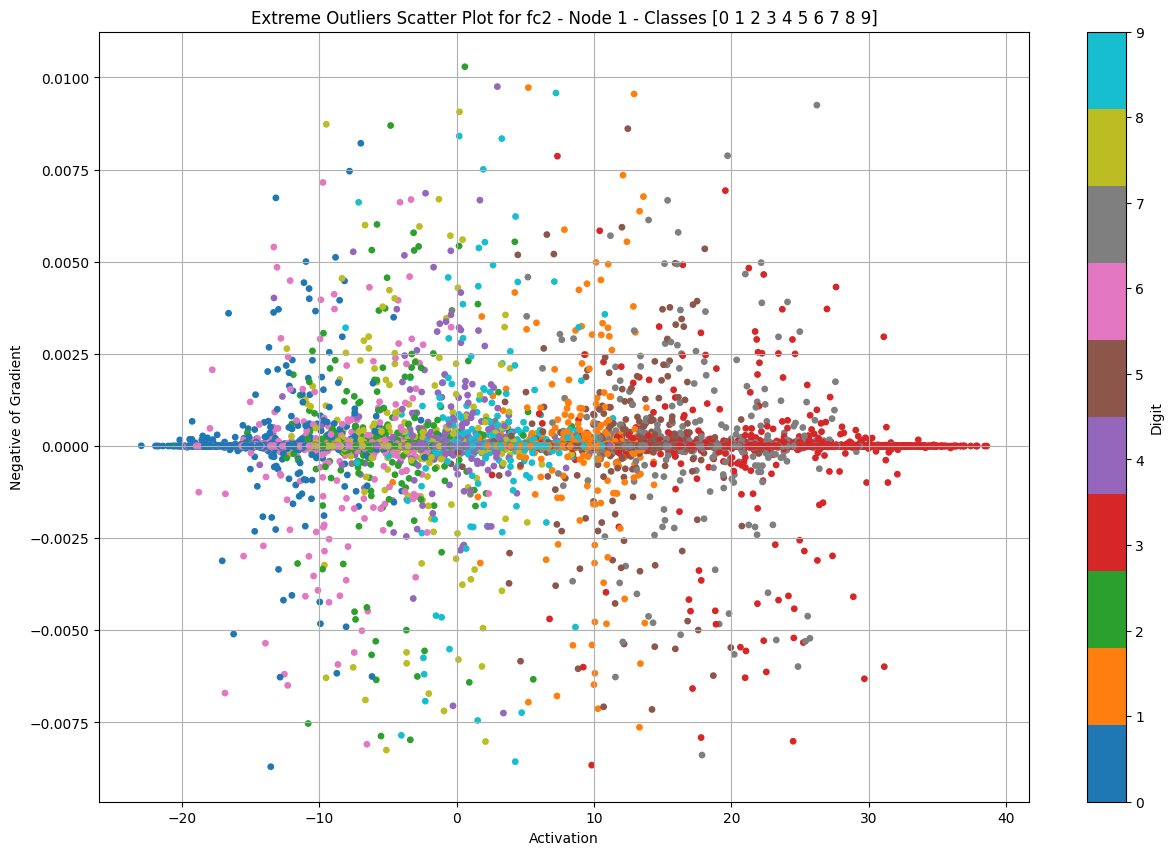

<ipython-input-97-69a82d847696>:62: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(df.loc[:, ['Activations']], df.loc[:, ['Gradients']], c= colors_extreme, cmap=color_map, s=15)


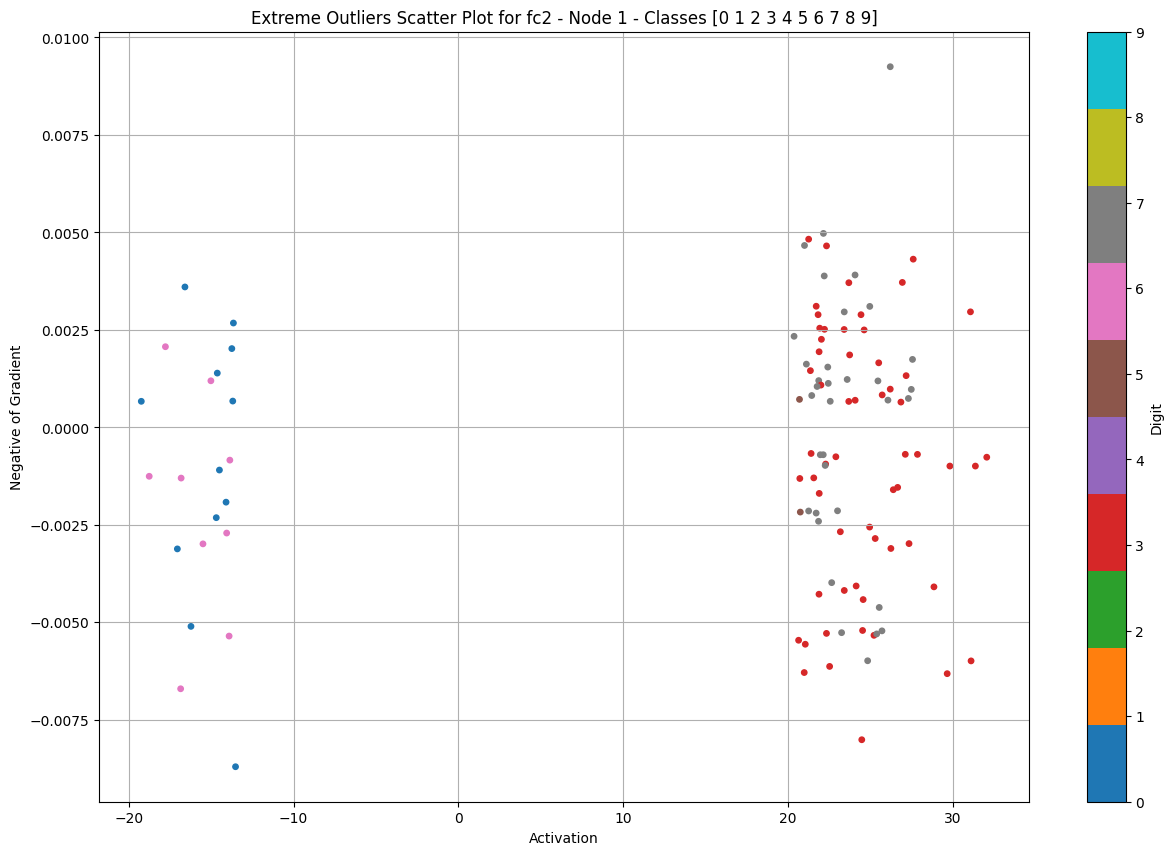

<ipython-input-97-69a82d847696>:62: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(df.loc[:, ['Activations']], df.loc[:, ['Gradients']], c= colors_extreme, cmap=color_map, s=15)


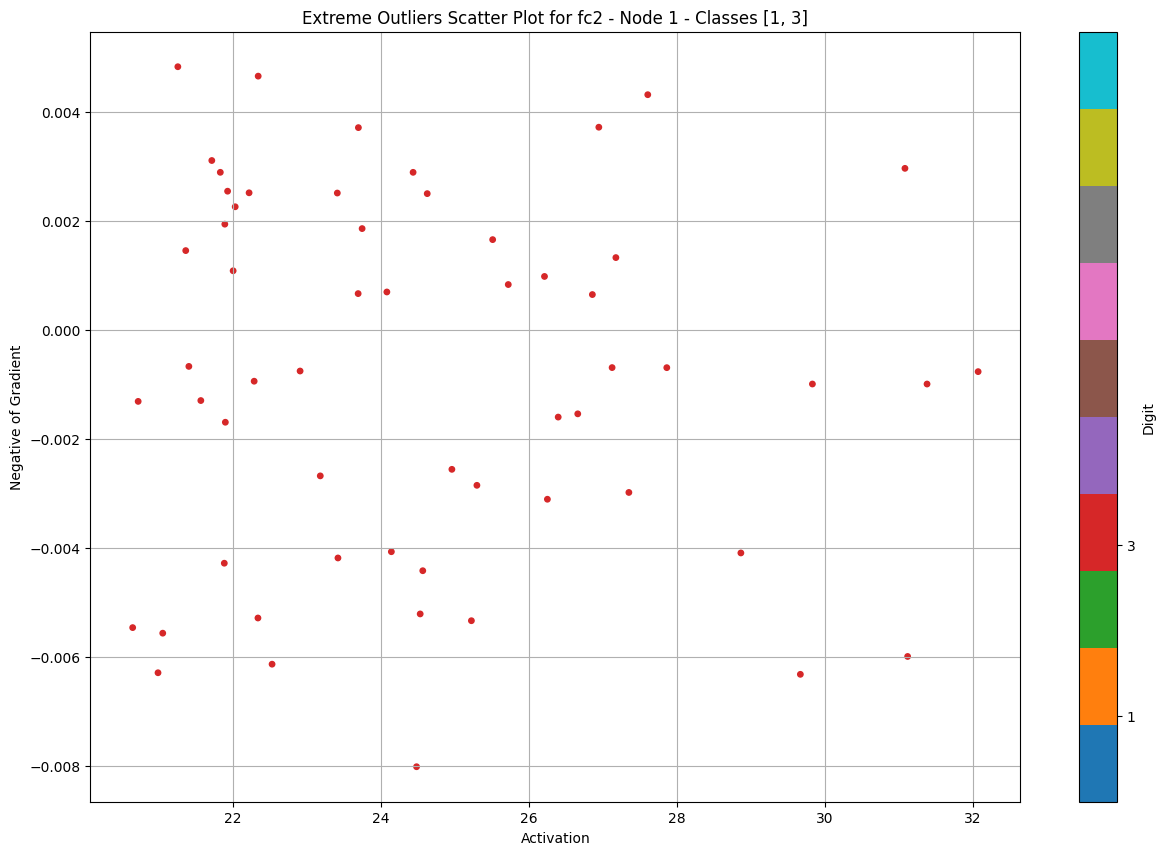

In [97]:
def plot_extreme_outliers(explainable_network, layer_name, node_index, std_dev_threshold=3, discriminate_classes=[], Correct_pred_only=False):
    activations = []
    gradients = []
    colors = []
    labels = []

    # Define a color map for digits 0-9
    color_map = matplotlib.colormaps['tab10']

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        if expected == predicted or not Correct_pred_only:
            activation = explainable_network.get_activations(input_index)
            gradient = explainable_network.get_gradients(input_index)

            if activation is not None and gradient is not None:
                activations.append(activation[layer_name][node_index])
                gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
                colors.append(color_map(expected))  # Color code based on the correct digit
                labels.append(expected)


    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    labels = np.array(labels)
    colors = np.array(colors)

    if activations.ndim != 1:
        activations = np.mean(activations, axis=(1, 2))
        gradients = np.mean(gradients, axis=(1, 2))
        print(activations)

    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)


    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers]
    gradients_extreme = gradients[extreme_outliers]
    labels_extreme = labels[extreme_outliers]
    colors_extreme = colors[extreme_outliers]

    # Create Dataframe for easy use
    df = pd.DataFrame({'Activations': activations_extreme, 'Gradients': gradients_extreme, 'Labels': labels_extreme})

    if discriminate_classes:
        colors_extreme = colors_extreme[df['Labels'].isin(discriminate_classes)]
        df = df[df['Labels'].isin(discriminate_classes)]
    else:
        discriminate_classes = np.arange(0, 10)

    # Generate scatter plot with extreme outliers
    fig, ax = plt.subplots(figsize=(15, 10))
    scatter = ax.scatter(df.loc[:, ['Activations']], df.loc[:, ['Gradients']], c= colors_extreme, cmap=color_map, s=15)
    ax.set_xlabel('Activation')
    ax.set_ylabel('Negative of Gradient')
    ax.set_title(f'Extreme Outliers Scatter Plot for {layer_name} - Node {node_index} - Classes {discriminate_classes}')

    # Create a colorbar
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(0, 9)), ax=ax, ticks=discriminate_classes)
    cbar.set_label('Digit')

    ax.grid(True)
    plt.show()

#Inputs [std_dev_threshold, discriminate_classes, Correct_pred_only] are optional
# Example usage for all classes for node 3 of layer fc2:
#plot_extreme_outliers(explainable_net, 'fc1', 3, std_dev_threshold=1, Correct_pred_only=False)  # Adjust std_dev_threshold as needed

# Example usage for multiple classes [0,2] for node 3 of layer fc2:
#plot_extreme_outliers(explainable_net, 'fc2', 3, std_dev_threshold=1, discriminate_classes=[0,2], Correct_pred_only=False)  # Adjust std_dev_threshold as needed

# Example usage for multiple classes [0,1,2,3] for node 3 of layer fc2:
#plot_extreme_outliers(explainable_net, 'fc2', 3, std_dev_threshold=1, discriminate_classes=[0,1,2,3], Correct_pred_only=False)  # Adjust std_dev_threshold as needed

layer_name = 'fc2'
node_index = 1
std_dev = 1.5

plot_extreme_outliers(explainable_net, layer_name, node_index, std_dev_threshold=0, Correct_pred_only=False)

plot_extreme_outliers(explainable_net, layer_name, node_index, std_dev_threshold=std_dev, Correct_pred_only=False)

plot_extreme_outliers(explainable_net, layer_name, node_index, std_dev_threshold=std_dev, Correct_pred_only=False, discriminate_classes=[1,3])

<ipython-input-98-f239866427c4>:89: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(df.loc[:, ['Activations']], df.loc[:, ['Gradients']], c=colors_extreme, cmap=color_map, s=15)


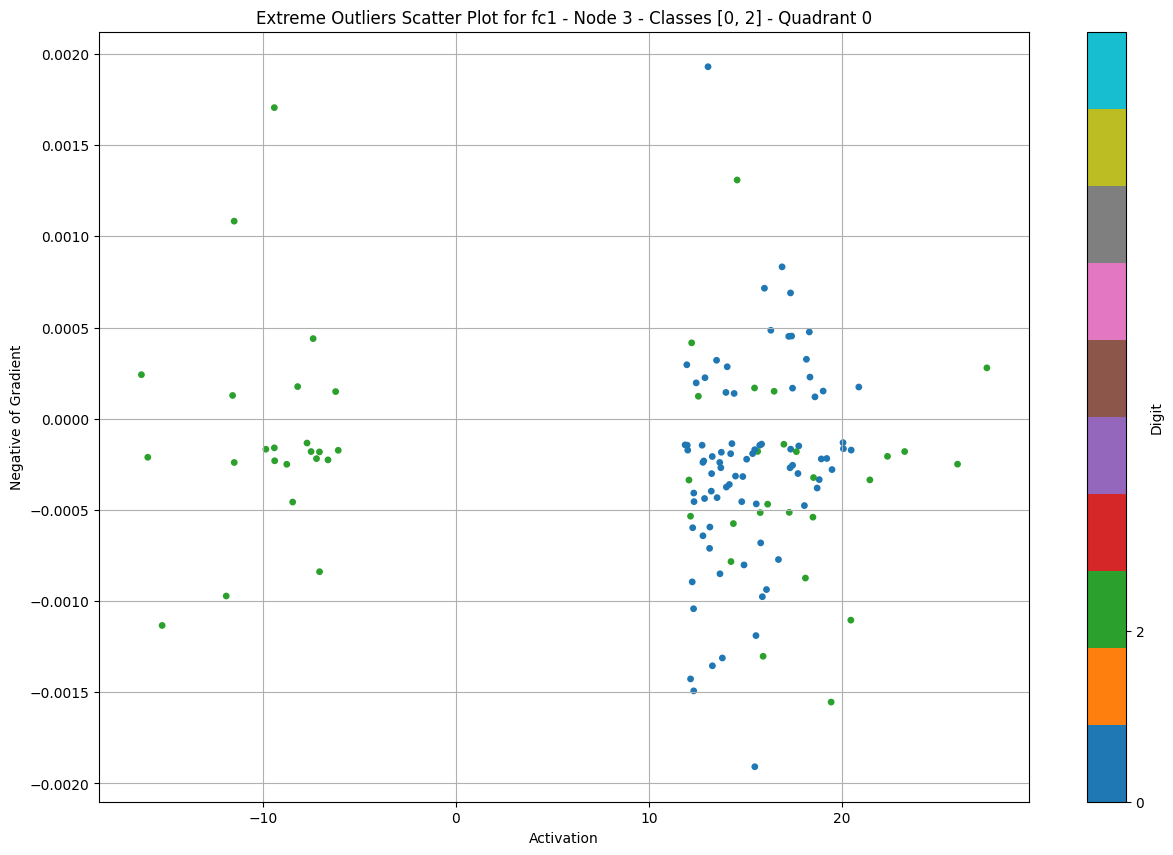

In [98]:
def plot_extreme_outliers_quad(explainable_network, layer_name, node_index, quadrant, std_dev_threshold=3, discriminate_classes=[]):
    activations = []
    gradients = []
    labels = []
    imgIndx = []
    colors = []

     # Define a color map for digits 0-9
    color_map = matplotlib.colormaps['tab10']

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        #if expected == predicted: do we want to filter this?
        activation = explainable_network.get_activations(input_index)
        gradient = explainable_network.get_gradients(input_index)

        if activation is not None and gradient is not None:
            activations.append(activation[layer_name][node_index])
            gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
            labels.append(expected)
            imgIndx.append(input_index)
            colors.append(color_map(expected))  # Color code based on the correct digit


    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    labels = np.array(labels)
    imgIndx = np.array(imgIndx)
    colors = np.array(colors)

    if activations.ndim != 1:
        activations = np.mean(activations, axis=(1, 2))
        gradients = np.mean(gradients, axis=(1, 2))
        print(activations)


    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)

    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers]
    gradients_extreme = gradients[extreme_outliers]
    labels_extreme = labels[extreme_outliers]
    colors_extreme = colors[extreme_outliers]
    imgIndx = imgIndx[extreme_outliers]

    # Create Dataframe for easy use
    df = pd.DataFrame({'Index':imgIndx,'Activations': activations_extreme, 'Gradients': gradients_extreme, 'Labels': labels_extreme})

    if discriminate_classes:
        colors_extreme = colors_extreme[df['Labels'].isin(discriminate_classes)]
        df = df[df['Labels'].isin(discriminate_classes)]
    else:
        discriminate_classes = np.arange(0, 10)

    if quadrant == 1:
        colors_extreme = colors_extreme[df['Gradients'] > 0]
        df = df[df['Gradients'] > 0]
        colors_extreme = colors_extreme[df['Activations'] > 0]
        df = df[df['Activations'] > 0]
    elif quadrant == 2:
        colors_extreme = colors_extreme[df['Gradients'] > 0]
        df = df[df['Gradients'] > 0]
        colors_extreme = colors_extreme[df['Activations'] < 0]
        df = df[df['Activations'] < 0]

    elif quadrant == 3:
        colors_extreme = colors_extreme[df['Gradients'] < 0]
        df = df[df['Gradients'] < 0]
        colors_extreme = colors_extreme[df['Activations'] < 0]
        df = df[df['Activations'] < 0]

    elif quadrant == 4:
        colors_extreme = colors_extreme[df['Gradients'] < 0]
        df = df[df['Gradients'] < 0]
        colors_extreme = colors_extreme[df['Activations'] > 0]
        df = df[df['Activations'] > 0]

    # Generate scatter plot with extreme outliers
    fig, ax = plt.subplots(figsize=(15, 10))
    scatter = ax.scatter(df.loc[:, ['Activations']], df.loc[:, ['Gradients']], c=colors_extreme, cmap=color_map, s=15)
    ax.set_xlabel('Activation')
    ax.set_ylabel('Negative of Gradient')
    ax.set_title(f'Extreme Outliers Scatter Plot for {layer_name} - Node {node_index} - Classes {discriminate_classes} - Quadrant {quadrant}')

    # Create a colorbar
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(0, 9)), ax=ax, ticks=discriminate_classes)
    cbar.set_label('Digit')

    ax.grid(True)
    plt.show()

# Example usage:
# plot_extreme_outliers_quad(explainable_net, 'conv2', 3, std_dev_threshold=1, quadrant= 0, discriminate_classes=[0])  # Adjust std_dev_threshold as needed
plot_extreme_outliers_quad(explainable_net, 'fc1', 3, std_dev_threshold=1, quadrant= 0, discriminate_classes=[0,2])  # Adjust std_dev_threshold as needed


In [99]:
def extreme_outliers_quad(explainable_network, layer_name, node_index, quadrant, std_dev_threshold=3, discriminate_classes=[]):
    activations = []
    gradients = []
    labels = []
    imgIndx = []

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        #if expected == predicted: do we want to filter this?
        activation = explainable_network.get_activations(input_index)
        gradient = explainable_network.get_gradients(input_index)

        if activation is not None and gradient is not None:
            activations.append(activation[layer_name][node_index])
            gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
            labels.append(expected)
            imgIndx.append(input_index)


    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    labels = np.array(labels)
    imgIndx = np.array(imgIndx)

    if activations.ndim != 1:
        activations = np.mean(activations, axis=(1, 2))
        gradients = np.mean(gradients, axis=(1, 2))


    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)

    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers]
    gradients_extreme = gradients[extreme_outliers]

    labels_extreme = labels[extreme_outliers]
    imgIndx = imgIndx[extreme_outliers]

    # Create Dataframe for easy use
    df = pd.DataFrame({'Index':imgIndx,'Activations': activations_extreme, 'Gradients': gradients_extreme, 'Labels': labels_extreme})

    if discriminate_classes:
        df = df[df['Labels'].isin(discriminate_classes)]
    else:
        discriminate_classes = np.arange(0, 10)

    if quadrant == 1:
        df = df[df['Activations'] > 0]
        df = df[df['Gradients'] > 0]

    elif quadrant == 2:
        df = df[df['Activations'] < 0]
        df = df[df['Gradients'] > 0]

    elif quadrant == 3:
        df = df[df['Activations'] < 0]
        df = df[df['Gradients'] < 0]

    elif quadrant == 4:
        df = df[df['Activations'] > 0]
        df = df[df['Gradients'] < 0]

    return df['Index'].values


# Example usage:


#Pass the selected class you want to selected_class to obtain a specific label class
# print("Extreme Outliers of all classes in quadrant 1\n\n")
# extreme_outliers_quad(explainable_net, 'conv1', 3, std_dev_threshold=1, quadrant= 0)

print("\n\nExtreme Outliers of class 0 in quadrant 1\n")
print(extreme_outliers_quad(explainable_net, 'fc2', 3, std_dev_threshold=1, quadrant= 0, discriminate_classes=[0]))

print("\n\nExtreme Outliers of classes 0 and 2 in quadrant 1\n\n")
print(extreme_outliers_quad(explainable_net, 'fc2', 3, std_dev_threshold=1, quadrant= 0, discriminate_classes=[0, 2]))

print("\n\nExtreme Outliers of classes 0, 2, and 4 in quadrant 1\n\n")
print(extreme_outliers_quad(explainable_net, 'fc2', 3, std_dev_threshold=1, quadrant= 0, discriminate_classes=[0, 2, 4]))




Extreme Outliers of class 0 in quadrant 1

[ 2084  5514  6935  9524 10080 11514 18718 25754 26620 32144 39028 42985
 44326 46812 53524 58376]


Extreme Outliers of classes 0 and 2 in quadrant 1


[ 2084  3676  4185  5156  5514  6935  8632  9248  9524 10080 11514 18718
 25754 26325 26620 32144 32545 33662 34462 38618 39006 39028 42598 42985
 44326 46812 49034 49573 53524 58376]


Extreme Outliers of classes 0, 2, and 4 in quadrant 1


[ 1180  2084  3676  4185  5156  5514  6935  7296  8632  9248  9465  9524
 10080 10918 11514 12472 14715 15787 16738 18088 18718 18846 20182 20262
 20950 25754 26325 26620 32144 32545 33662 34462 36346 36466 37958 38402
 38618 39006 39028 39365 39809 41626 42598 42985 44264 44326 44464 46766
 46812 47044 47477 49034 49102 49546 49573 49942 50152 53524 57114 58376]


In [100]:
import pandas as pd

def extreme_outliers_quad(explainable_network, layer_name, node_index, quadrant, std_dev_threshold=3, selected_class=-1):
    activations = []
    gradients = []
    labels = []
    imgIndx = []

    # Retrieve activations, gradients, and check for correct predictions
    for input_index, (expected, predicted) in enumerate(zip(explainable_network.expected_outputs, explainable_network.predicted_outputs)):
        #if expected == predicted: do we want to filter this?
        activation = explainable_network.get_activations(input_index)
        gradient = explainable_network.get_gradients(input_index)

        if activation is not None and gradient is not None:
            activations.append(activation[layer_name][node_index])
            gradients.append(-gradient[layer_name][node_index])  # Negative of the gradient
            labels.append(expected)
            imgIndx.append(input_index)


    # Convert lists to numpy arrays for numerical operations
    activations = np.array(activations)
    gradients = np.array(gradients)
    labels = np.array(labels)
    imgIndx = np.array(imgIndx)


    # Calculate mean and standard deviation for activations and gradients
    activation_mean = np.mean(activations)
    activation_std = np.std(activations)
    gradient_mean = np.mean(gradients)
    gradient_std = np.std(gradients)

    # Apply filtering for points that are more than std_dev_threshold away in both dimensions
    extreme_outliers = (np.abs(activations - activation_mean) > std_dev_threshold * activation_std) & \
                       (np.abs(gradients - gradient_mean) > std_dev_threshold * gradient_std)

    # Filter activations, gradients, and colors based on the extreme outlier condition
    activations_extreme = activations[extreme_outliers]
    gradients_extreme = gradients[extreme_outliers]
    labels_extreme = labels[extreme_outliers]
    imgIndx = imgIndx[extreme_outliers]

    # Create Dataframe for easy use
    df = pd.DataFrame({'Index':imgIndx,'Activations': activations_extreme, 'Gradients': gradients_extreme, 'Labels': labels_extreme})

    if selected_class > -1:
        df = df[df['Labels'] == selected_class]

    if quadrant == 1:
        df = df[df['Activations'] > 0]
        df = df[df['Gradients'] > 0]

    elif quadrant == 2:
        df = df[df['Activations'] < 0]
        df = df[df['Gradients'] > 0]

    elif quadrant == 3:
        df = df[df['Activations'] < 0]
        df = df[df['Gradients'] < 0]

    elif quadrant == 4:
        df = df[df['Activations'] > 0]
        df = df[df['Gradients'] < 0]

    return df['Index'].values


# Example usage:
displayPos = extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant= 1)  # Adjust std_dev_threshold as needed
displayNeg = extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant= 3)  # Adjust std_dev_threshold as needed

truePos =  extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant= 1, selected_class = 1)
trueNeg =  extreme_outliers_quad(explainable_net, 'fc2', node_index, std_dev_threshold=1.5, quadrant= 3, selected_class = 3)


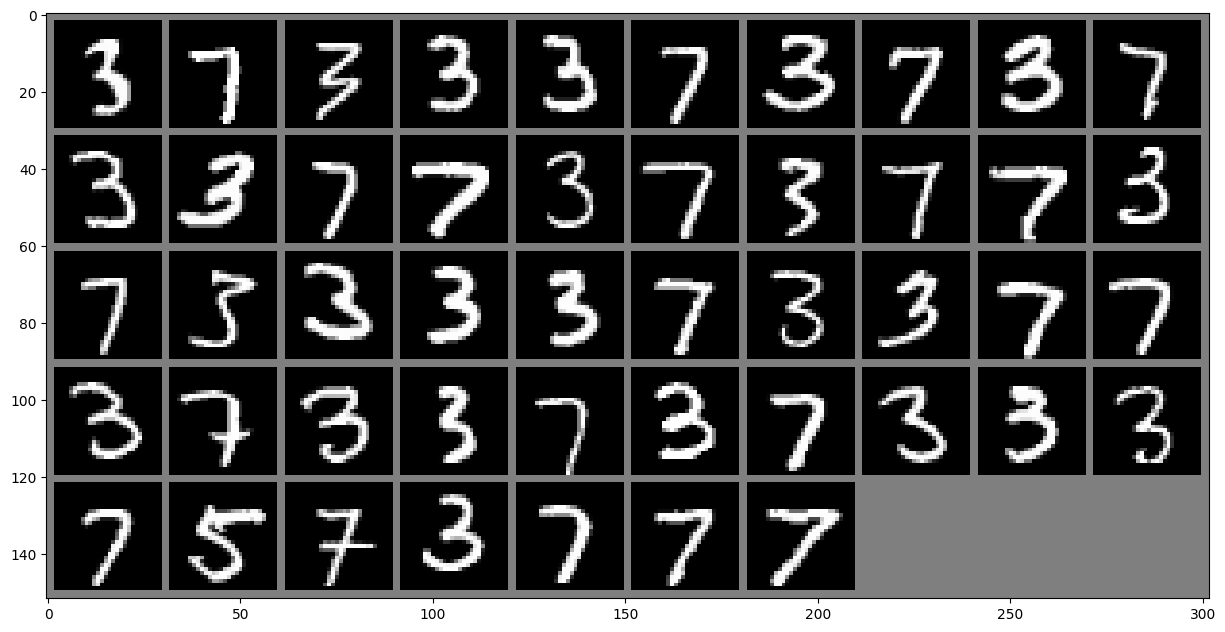

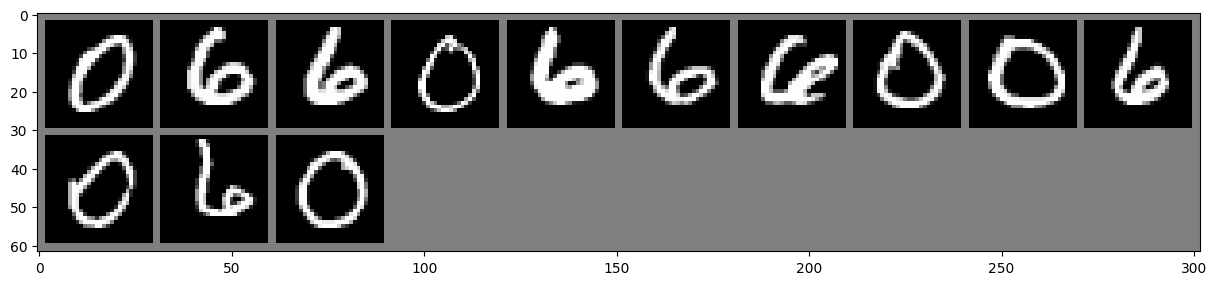

In [101]:
def display_image_grid(images, rows, cols):
    grid = torchvision.utils.make_grid(images, nrow=cols)
    grid = grid / 2 + 0.5  # Unnormalize
    plt.figure(figsize=(15, 15))  # Adjust the size as needed
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

# Number of images per grid
images_per_grid = 128  # for example, a 4x4 grid

# Calculate rows and columns for the grid
cols = 10  # Number of columns
rows = images_per_grid // cols

# Display the images in grids
for i in range(0, len(displayPos), images_per_grid):
    selected_indices = displayPos[i:i+images_per_grid]
    selected_images = torch.stack([all_images[index] for index in selected_indices])
    display_image_grid(selected_images, rows, cols)

for i in range(0, len(displayNeg), images_per_grid):
    selected_indices = displayNeg[i:i+images_per_grid]
    selected_images = torch.stack([all_images[index] for index in selected_indices])
    display_image_grid(selected_images, rows, cols)

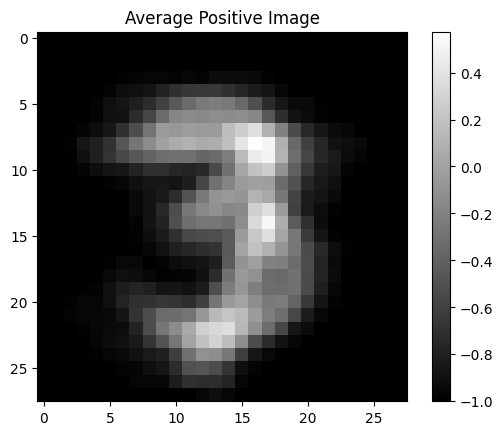

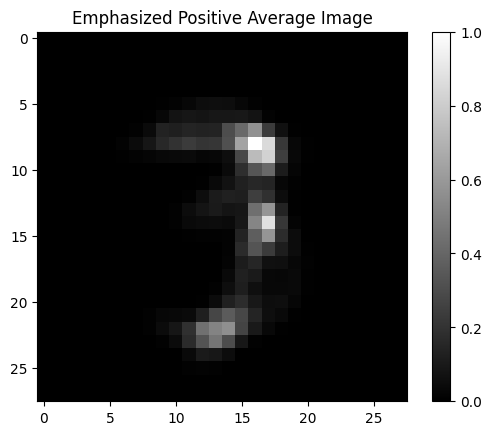

In [102]:
images_subset = torch.stack([all_images[i] for i in displayPos])
average_image = images_subset.float().mean(dim=0).squeeze()
plt.imshow(average_image, cmap='gray')
plt.title("Average Positive Image")
plt.colorbar()
plt.show()

normalized_image = (average_image - average_image.min()) / (average_image.max() - average_image.min())

# Apply a power law transformation to increase contrast, emphasizing the bright pixels
# Squaring the normalized pixel values will make high values brighter and low values dimmer
emphasized_positive_image = normalized_image ** 4

# Plot the emphasized average image
plt.imshow(emphasized_positive_image, cmap='gray')
plt.title("Emphasized Positive Average Image")
plt.colorbar()
plt.show()

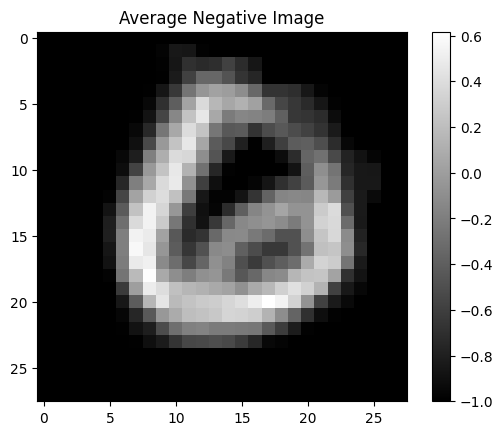

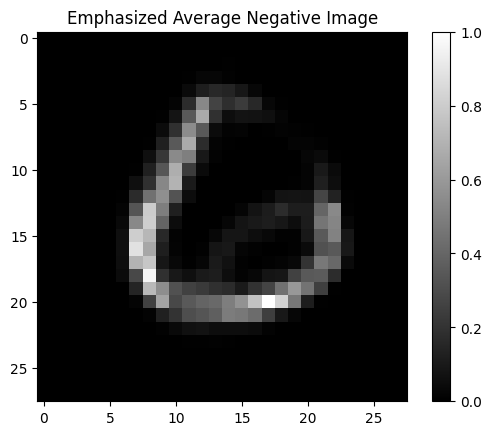

In [103]:
images_subset = torch.stack([all_images[i] for i in displayNeg])
average_image = images_subset.float().mean(dim=0).squeeze()
plt.imshow(average_image, cmap='gray')
plt.title("Average Negative Image")
plt.colorbar()
plt.show()

normalized_image = (average_image - average_image.min()) / (average_image.max() - average_image.min())

# Apply a power law transformation to increase contrast, emphasizing the bright pixels
# Squaring the normalized pixel values will make high values brighter and low values dimmer
emphasized_negative_image = normalized_image ** 4

# Plot the emphasized average image
plt.imshow(emphasized_negative_image, cmap='gray')
plt.title("Emphasized Average Negative Image")
plt.colorbar()
plt.show()

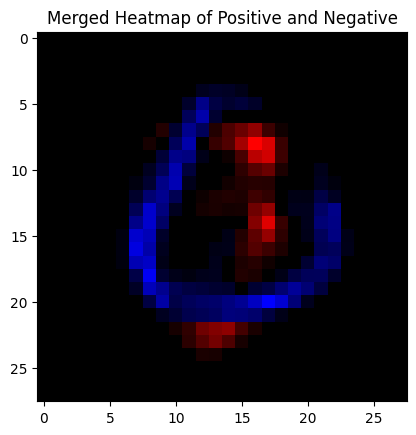

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# TODO do some math to average pos and neg not just > or <

# Create an empty RGB image
heatmap = np.zeros((*emphasized_positive_image.shape, 3))

# Define a threshold for neutrality
threshold = 0.05  # Adjust based on your data's scale

# Fill the heatmap
for i in range(heatmap.shape[0]):
    for j in range(heatmap.shape[1]):
        pos = emphasized_positive_image[i, j]
        neg = emphasized_negative_image[i, j]
        if np.abs(pos - neg) < threshold:  # Neutral
            heatmap[i, j] = [0, 0, 0]  # White for neutral, change to [0, 0, 0] for black
        elif pos > neg:  # Positive
            heatmap[i, j] = [pos, 0, 0]  # Red intensity based on positive value
        else:  # Negative
            heatmap[i, j] = [0, 0, neg]  # Blue intensity based on negative value

# Display the heatmap
plt.imshow(heatmap)
plt.title("Merged Heatmap of Positive and Negative")
plt.show()

In [105]:
trueNegData = []
truePosData = []

# Function to fetch data for each image index
def fetch_data_for_images(image_indices):
    data_array = []
    for index in image_indices:
        data = explainable_net.get_node_input(layer_name, node_index, index)
        data_array.append(data)
    return data_array

# Fetching data for trueNeg and truePos
trueNegData = fetch_data_for_images(trueNeg)
truePosData = fetch_data_for_images(truePos)